In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import nnfs
from nnfs.datasets import spiral_data
import random
import requests
from NNS import NeuralNetwork as NN #import neural net code from github to reduce copy/pasting
from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier

# Chapter 15
## Dropout
Helps correct co-adoption (neurons depending too much on outputs of other neurons and not learning), helps with noise, helps with overfitting

### Forward Pass

Example of one dopout layer

In [3]:
dropout_rate = 0.3 #% of nodes to dropout

example_output = np.random.normal(0,1,10)

example_output *= np.random.binomial(1, 1-dropout_rate, example_output.shape) #Multiply each value by 0 or 1 based off of binomial distribution with probability 1-dropout_rate
example_output /= (1-dropout_rate) #Scale data back up to mimic the mean of the sum of all neurons before neurons were dropped

example_output

array([ 1.52933955, -1.19440702, -1.09349208, -2.57492045,  2.13347029,
        0.17296038, -0.23088164,  0.75825306, -0.        , -0.69755493])

Example showing how scaling mimics the mean of the sum of all neurons

In [4]:
dropout_rate = 0.3
example_output = np.random.normal(0,1,10)

print(f'Sum Initial {sum(example_output)}')

sums = []

for i in range(10000):
    
    example_output_2 = example_output * np.random.binomial(1, 1-dropout_rate, example_output.shape) / (1 - dropout_rate)
    sums.append(sum(example_output_2))
    
print(f'Mean SumL: {np.mean(sums)}')

Sum Initial -2.8714045068991423
Mean SumL: -2.8744144811619226


### Backward Pass

The gradient of the dropout layer is 0, if the node was dropped_out or $\frac{1}{1-\text{dropout rate}}$ if the node was not dropped out

In [5]:
class Layer_Dropout:
    
    # Init
    def __init__(self, rate):
        # Store rate, we invert it for use in the binomial distribution
        self.rate = 1 - rate
        
    # Forward Pass
    def forward(self, inputs):
        # Save input values
        self.inputs = inputs
        # Generate and save scaled mask
        self.binary_mask = np.random.binomial(1, self.rate, size = inputs.shape) / self.rate
        # Apply mask to output values
        self.output = inputs * self.binary_mask
        
    # Backward Pass
    def backward(self, dvalues):
        # Gradient on values
        self.dinputs = dvalues * self.binary_mask

In [18]:
X, y = spiral_data(samples=1000, classes=3)

dense1 = NN.Layer_Dense(2, 64, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4)
activation1 = NN.Activation_ReLU()
dropout1 = Layer_Dropout(0.1)
dense2 = NN.Layer_Dense(64,3)
loss_activation = NN.Activation_Softmax_Loss_CategoricalCrossentropy()
optimizer = NN.Optimizer_Adam(learning_rate=0.05, decay=5e-5)

for epoch in tqdm(range(10001)):
    
    dense1.forward(X)
    activation1.forward(dense1.output)
    dropout1.forward(activation1.output)
    dense2.forward(dropout1.output)
    data_loss = loss_activation.forward(dense2.output, y)
    regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)
    loss = data_loss + regularization_loss
    
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    dropout1.backward(dense2.dinputs)
    activation1.backward(dropout1.dinputs)
    dense1.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    
    # Validate the model
    #Create test dataset
    X_test, y_test = spiral_data(samples=100, classes=3)
    dense1.forward(X_test)
    activation1.forward(dense1.output)
    dropout1.forward(activation1.output)
    dense2.forward(dropout1.output)
    data_loss = loss_activation.forward(dense2.output, y_test)
    regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)
    validation_loss = data_loss + regularization_loss
    
    validation_predictions = np.argmax(loss_activation.output, axis=1)
    if len(y_test.shape) == 2:
        y_test = np.argmax(y_test, axis=1)
    validation_accuracy = np.mean(validation_predictions==y_test)
    
    if not epoch % 1000:
        print(  f'epoch: {epoch}, ' +
                f'acc: {accuracy :.3f} , ' +
                f'loss: {loss :.3f} (' +
                f'data_loss: {data_loss :.3f} , ' +
                f'reg_loss: {regularization_loss :.3f}), ' +
                f'lr: {optimizer.current_learning_rate}, ' +
                f'validation, acc: {validation_accuracy: .3f} , loss: {validation_loss: .3f}' )

  0%|          | 15/10001 [00:00<02:19, 71.72it/s]

epoch: 0, acc: 0.331 , loss: 1.099 (data_loss: 1.096 , reg_loss: 0.000), lr: 0.05, validation, acc:  0.340 , loss:  1.097


 10%|█         | 1014/10001 [00:14<02:06, 71.11it/s]

epoch: 1000, acc: 0.650 , loss: 0.782 (data_loss: 0.699 , reg_loss: 0.030), lr: 0.047619047619047616, validation, acc:  0.667 , loss:  0.729


 20%|██        | 2011/10001 [00:29<02:00, 66.49it/s]

epoch: 2000, acc: 0.655 , loss: 0.747 (data_loss: 0.716 , reg_loss: 0.025), lr: 0.045454545454545456, validation, acc:  0.670 , loss:  0.741


 30%|███       | 3012/10001 [00:44<01:56, 59.85it/s]

epoch: 3000, acc: 0.661 , loss: 0.727 (data_loss: 0.737 , reg_loss: 0.022), lr: 0.04347826086956522, validation, acc:  0.693 , loss:  0.759


 40%|████      | 4009/10001 [00:59<01:27, 68.61it/s]

epoch: 4000, acc: 0.653 , loss: 0.750 (data_loss: 0.706 , reg_loss: 0.020), lr: 0.04166666666666667, validation, acc:  0.677 , loss:  0.726


 50%|█████     | 5011/10001 [01:14<01:11, 69.32it/s]

epoch: 5000, acc: 0.677 , loss: 0.715 (data_loss: 0.710 , reg_loss: 0.019), lr: 0.04000000000000001, validation, acc:  0.657 , loss:  0.729


 60%|██████    | 6013/10001 [01:29<00:56, 70.22it/s]

epoch: 6000, acc: 0.680 , loss: 0.700 (data_loss: 0.742 , reg_loss: 0.018), lr: 0.038461538461538464, validation, acc:  0.650 , loss:  0.760


 70%|███████   | 7013/10001 [01:43<00:42, 69.66it/s]

epoch: 7000, acc: 0.659 , loss: 0.745 (data_loss: 0.691 , reg_loss: 0.018), lr: 0.037037037037037035, validation, acc:  0.653 , loss:  0.709


 80%|████████  | 8013/10001 [01:58<00:28, 70.35it/s]

epoch: 8000, acc: 0.658 , loss: 0.733 (data_loss: 0.756 , reg_loss: 0.017), lr: 0.03571428571428572, validation, acc:  0.663 , loss:  0.773


 90%|█████████ | 9010/10001 [02:12<00:13, 71.47it/s]

epoch: 9000, acc: 0.661 , loss: 0.717 (data_loss: 0.774 , reg_loss: 0.017), lr: 0.03448275862068966, validation, acc:  0.683 , loss:  0.791


100%|██████████| 10001/10001 [02:27<00:00, 67.91it/s]

epoch: 10000, acc: 0.657 , loss: 0.739 (data_loss: 0.685 , reg_loss: 0.017), lr: 0.03333333333333333, validation, acc:  0.703 , loss:  0.702


We see a worse training accuracy and loss, but our testing set is now performing better

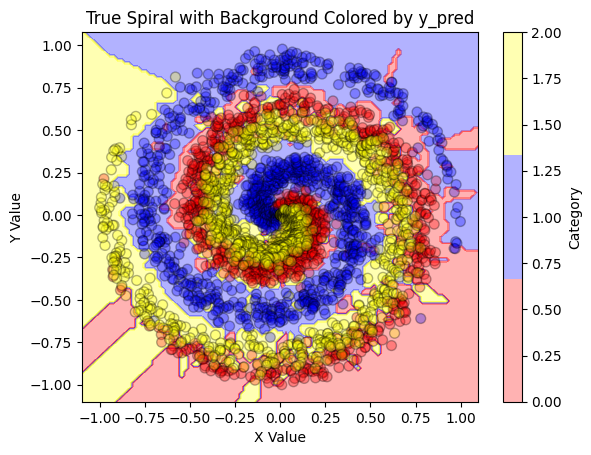

In [19]:
#  Create a meshgrid for the plot background
x_min, x_max = X[:, 0].min() -0.1 , X[:, 0].max() +0.1
y_min, y_max = X[:, 1].min() -0.1, X[:, 1].max() +0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Step 2: Predict the category for each point in the meshgrid based off of y_pred
# Using the nearest neighbors
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, predictions)

# Predict categories for the meshgrid points
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predictions back to the grid shape
Z = Z.reshape(xx.shape)

# Create the background color plot
cmap = ListedColormap(['red', 'blue', 'yellow'])  # Assign colors for each category
plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)  # Fill the regions with color

# Plot the scatter plot, 
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolors='k', s=50, alpha = 0.3)

# Add color bar to indicate values of y_pred
plt.colorbar(label='Category')

# Add labels and title
plt.xlabel('X Value')
plt.ylabel('Y Value')
plt.title('True Spiral with Background Colored by y_pred')

# Show the plot
plt.show()


More Neurons

  0%|          | 2/10001 [00:00<13:53, 12.00it/s]

epoch: 0, acc: 0.287 , loss: 1.099 (data_loss: 1.082 , reg_loss: 0.002), lr: 0.05, validation, acc:  0.440 , loss:  1.083


 10%|█         | 1002/10001 [01:30<17:58,  8.34it/s]

epoch: 1000, acc: 0.829 , loss: 0.516 (data_loss: 0.491 , reg_loss: 0.066), lr: 0.047619047619047616, validation, acc:  0.830 , loss:  0.558


 20%|██        | 2002/10001 [21:27:41<11:10, 11.94it/s]         

epoch: 2000, acc: 0.852 , loss: 0.460 (data_loss: 0.415 , reg_loss: 0.060), lr: 0.045454545454545456, validation, acc:  0.820 , loss:  0.474


 30%|███       | 3002/10001 [21:29:30<16:43,  6.97it/s]

epoch: 3000, acc: 0.853 , loss: 0.444 (data_loss: 0.460 , reg_loss: 0.056), lr: 0.04347826086956522, validation, acc:  0.830 , loss:  0.517


 40%|████      | 4002/10001 [21:31:14<10:11,  9.82it/s]

epoch: 4000, acc: 0.855 , loss: 0.441 (data_loss: 0.572 , reg_loss: 0.053), lr: 0.04166666666666667, validation, acc:  0.837 , loss:  0.625


 50%|█████     | 5003/10001 [21:32:52<07:07, 11.70it/s]

epoch: 5000, acc: 0.850 , loss: 0.445 (data_loss: 0.475 , reg_loss: 0.051), lr: 0.04000000000000001, validation, acc:  0.857 , loss:  0.526


 60%|██████    | 6003/10001 [21:34:24<05:53, 11.31it/s]

epoch: 6000, acc: 0.857 , loss: 0.469 (data_loss: 0.389 , reg_loss: 0.057), lr: 0.038461538461538464, validation, acc:  0.863 , loss:  0.446


 70%|███████   | 7002/10001 [21:35:56<04:35, 10.89it/s]

epoch: 7000, acc: 0.857 , loss: 0.441 (data_loss: 0.464 , reg_loss: 0.049), lr: 0.037037037037037035, validation, acc:  0.807 , loss:  0.513


 80%|████████  | 8003/10001 [21:37:32<03:00, 11.07it/s]

epoch: 8000, acc: 0.841 , loss: 0.466 (data_loss: 0.506 , reg_loss: 0.049), lr: 0.03571428571428572, validation, acc:  0.830 , loss:  0.555


 90%|█████████ | 9003/10001 [21:39:07<01:34, 10.62it/s]

epoch: 9000, acc: 0.849 , loss: 0.438 (data_loss: 0.436 , reg_loss: 0.047), lr: 0.03448275862068966, validation, acc:  0.840 , loss:  0.483


100%|██████████| 10001/10001 [21:40:41<00:00,  7.80s/it]

epoch: 10000, acc: 0.832 , loss: 0.504 (data_loss: 0.467 , reg_loss: 0.066), lr: 0.03333333333333333, validation, acc:  0.837 , loss:  0.532


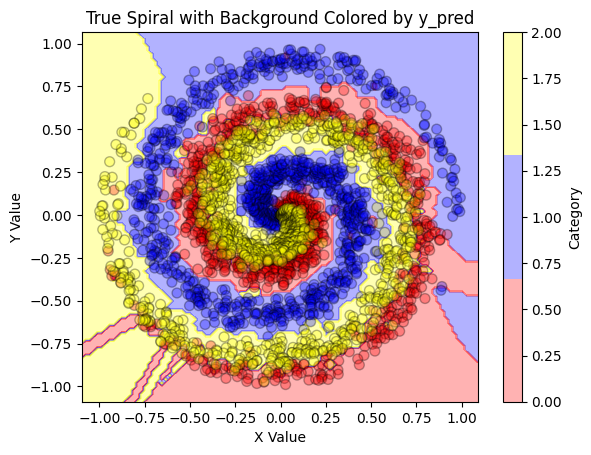

In [20]:
X, y = spiral_data(samples=1000, classes=3)

dense1 = NN.Layer_Dense(2, 512, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4)
activation1 = NN.Activation_ReLU()
dropout1 = Layer_Dropout(0.1)
dense2 = NN.Layer_Dense(512,3)
loss_activation = NN.Activation_Softmax_Loss_CategoricalCrossentropy()
optimizer = NN.Optimizer_Adam(learning_rate=0.05, decay=5e-5)

for epoch in tqdm(range(10001)):
    
    dense1.forward(X)
    activation1.forward(dense1.output)
    dropout1.forward(activation1.output)
    dense2.forward(dropout1.output)
    data_loss = loss_activation.forward(dense2.output, y)
    regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)
    loss = data_loss + regularization_loss
    
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    dropout1.backward(dense2.dinputs)
    activation1.backward(dropout1.dinputs)
    dense1.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    
    # Validate the model
    #Create test dataset
    X_test, y_test = spiral_data(samples=100, classes=3)
    dense1.forward(X_test)
    activation1.forward(dense1.output)
    dropout1.forward(activation1.output)
    dense2.forward(dropout1.output)
    data_loss = loss_activation.forward(dense2.output, y_test)
    regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)
    validation_loss = data_loss + regularization_loss
    
    validation_predictions = np.argmax(loss_activation.output, axis=1)
    if len(y_test.shape) == 2:
        y_test = np.argmax(y_test, axis=1)
    validation_accuracy = np.mean(validation_predictions==y_test)
    
    if not epoch % 1000:
        print(  f'epoch: {epoch}, ' +
                f'acc: {accuracy :.3f} , ' +
                f'loss: {loss :.3f} (' +
                f'data_loss: {data_loss :.3f} , ' +
                f'reg_loss: {regularization_loss :.3f}), ' +
                f'lr: {optimizer.current_learning_rate}, ' +
                f'validation, acc: {validation_accuracy: .3f} , loss: {validation_loss: .3f}' )
    
#  Create a meshgrid for the plot background
x_min, x_max = X[:, 0].min() -0.1 , X[:, 0].max() +0.1
y_min, y_max = X[:, 1].min() -0.1, X[:, 1].max() +0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Step 2: Predict the category for each point in the meshgrid based off of y_pred
# Using the nearest neighbors
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, predictions)

# Predict categories for the meshgrid points
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predictions back to the grid shape
Z = Z.reshape(xx.shape)

# Create the background color plot
cmap = ListedColormap(['red', 'blue', 'yellow'])  # Assign colors for each category
plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)  # Fill the regions with color

# Plot the scatter plot, 
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolors='k', s=50, alpha = 0.3)

# Add color bar to indicate values of y_pred
plt.colorbar(label='Category')

# Add labels and title
plt.xlabel('X Value')
plt.ylabel('Y Value')
plt.title('True Spiral with Background Colored by y_pred')

# Show the plot
plt.show()